In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Шаг 1. Подготовка данных

Создадим объекты для необходимых трансформаций нашего датасета:

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
zip_file_path = 'drive/MyDrive/HandGestRecog.zip'

In [9]:
!unzip -q {zip_file_path} -d /content/

In [10]:
data_dir = './HandGestRecog'
print(os.listdir(data_dir))

['04_fist_moved', '02_l', '07_ok', '08_palm_moved', '05_thumb', '03_fist', '10_down', '01_palm', '09_c', '06_index']


Если посмотрим что в них, то у видим 10 папок. Каждая под один из 10 классов жестов:

In [11]:
classes = os.listdir(data_dir)
classes = sorted(classes)
print(f'Classes - {classes}')

Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


Используем ImageFolder для каждой выборки:

In [12]:
tfms = tt.Compose([tt.CenterCrop(size=(240, 440)),    # Обрежем лишнее пустое пространство по бокам
                   tt.Resize((100, 183)),
                   tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()])

In [13]:
dataset = ImageFolder(root=data_dir, transform=tfms)

# Разделяем данные на обучающую и тестовую выборки
train_size = 3750
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

In [30]:
train_ds[0][0].size()

torch.Size([1, 100, 183])

Определим размер батча:

In [14]:
batch_size = 84

И создадим наши даталоадеры:

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [31]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 100, 183])


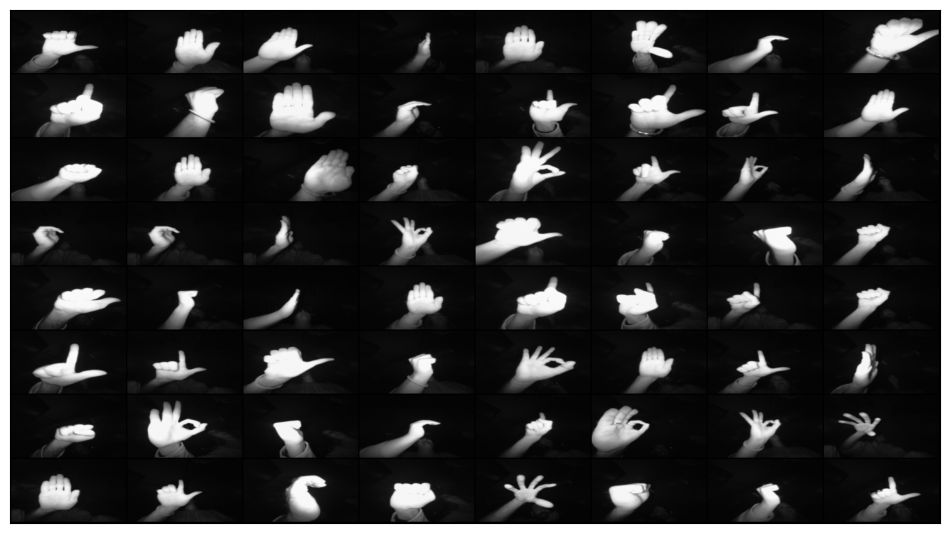

In [32]:
show_batch(train_dl)

Напишем функции для перевода наших даталоадеров на необходимое оборудование:

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

Узнаем какое оборудование у нас:

In [17]:
device = get_default_device()
device

device(type='cuda')

Воспользуемся функциями написанными выше:

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Шаг 2. Опишем модель

Опишем нашу модель для распознавания эмоций:

In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(64, 128)
        self.conv4 = conv_block(128, 128, pool=True)
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop2 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                        nn.Flatten(),
                                        nn.Linear(128, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet(1, len(classes)), device)

In [ ]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

# Шаг 3. Обучение

In [ ]:
torch.cuda.empty_cache()
history = []

epochs = 24
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [ ]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

24 epochs, 45 total_steps per epoch


In [ ]:
epoch_losses = []
best_val_loss = float('inf')
patience = 4
counter = 0

for epoch in range(epochs):

    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()


        optimizer.zero_grad()

        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    if np.mean(epoch_loss) < best_val_loss:
           best_val_loss = np.mean(epoch_loss)
           counter = 0
    else:
           counter += 1
           if counter >= patience:
               print("Early stopping at epoch {}".format(epoch+1))
               break

Epoch 1, loss:  1.750941636827257
Epoch 2, loss:  1.029661688539717
Epoch 3, loss:  0.7231481207741631
Epoch 4, loss:  0.43866405652629004
Epoch 5, loss:  0.26337123844358656
Epoch 6, loss:  0.21143066005574332
Epoch 7, loss:  0.09906648769974709
Epoch 8, loss:  0.07027009973923365
Epoch 9, loss:  0.0671472972465886
Epoch 10, loss:  0.08569917546378242
Epoch 11, loss:  0.08228292469349173
Epoch 12, loss:  0.0586633803943793
Epoch 13, loss:  0.05505727057655652
Epoch 14, loss:  0.024214422599309022
Epoch 15, loss:  0.02370320800691843
Epoch 16, loss:  0.05171112347808149
Epoch 17, loss:  0.07149700903230244
Epoch 18, loss:  0.020820163355933296
Epoch 19, loss:  0.0202348789303667
Epoch 20, loss:  0.14370614728993839
Epoch 21, loss:  0.04747211167381869
Epoch 22, loss:  0.021630795300006868
Epoch 23, loss:  0.01106508454411394
Epoch 24, loss:  0.014064684530927076


Посмотрим на нашу ошибку в процессе обучения:

Text(0.5, 1.0, 'losses vs. No. of epochs')

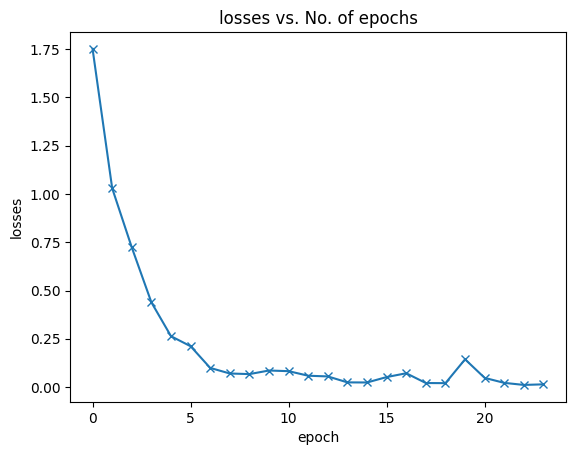

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

Сохраним нашу модель:

In [ ]:
torch.save(model.state_dict(), './gesture_detection_model_state_5.pth')

Лучшая модель: ./gesture_detection_model_state_2.pth (12/12, final loss: 0.039) (Все параметры те же, просто более удачный запуск):

In [21]:
net=ResNet(1, len(classes)).to(device)
net.load_state_dict(torch.load('./gesture_detection_model_state_2.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

# Шаг 4. Оценка


Прогоним нашу нейронную сеть через тестовый датасет:

In [22]:
y_true = []
y_pred = []

In [23]:
with torch.no_grad():
    for images, labels in test_dl:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

Accuracy: 0.9771
Precision: 0.9787
Recall: 0.9770
F1-score: 0.9771
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1105
           1       1.00      0.92      0.96      1109
           2       0.93      1.00      0.96      1147
           3       1.00      0.96      0.98      1145
           4       0.99      1.00      0.99      1107
           5       0.97      0.98      0.97      1149
           6       0.99      1.00      1.00      1121
           7       1.00      1.00      1.00      1129
           8       1.00      0.92      0.96      1122
           9       0.91      1.00      0.95      1116

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250

[[1105    0    0    0    0    0    0    0    0    0]
 [   1 1019   36    0    8   40    0    0    0    5]
 [   0    0 1147    0    0    0    0    0    0    0]
 [   0    0   4